Definimos la ruta al archivo e importamos la clase creada de preprocesado

In [17]:
import sys
sys.path.append('/Users/kento/Desktop/Projects/BANK_CHURN/churn-api') 
from app.model.preprocessing import CustomPreprocessor

Importamos las librerías

In [14]:
import pandas as pd 
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_excel('Telco_customer_churn.xlsx')
RANDOM_STATE = 42

## Limpieza de los datos

### Consulta de los tipos de datos

Primero verificaremos si todas las columnas están en un formato coherente

In [32]:
df.dtypes

CustomerID            object
Count                  int64
Country               object
State                 object
City                  object
Zip Code               int64
Lat Long              object
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Label           object
Churn Value            int64
Churn Score            int64
CLTV                   int64
Churn Reason          object
dtype: object

Salta a la vista que 'Total Charges' no tiene formato numérico, por lo que lo cambiaremos posteriormente

### Detección de faltantes

In [4]:
df.isnull().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

In [7]:
df[df == ' '].any()


CustomerID           False
Count                False
Country              False
State                False
City                 False
Zip Code             False
Lat Long             False
Latitude             False
Longitude            False
Gender               False
Senior Citizen       False
Partner              False
Dependents           False
Tenure Months        False
Phone Service        False
Multiple Lines       False
Internet Service     False
Online Security      False
Online Backup        False
Device Protection    False
Tech Support         False
Streaming TV         False
Streaming Movies     False
Contract             False
Paperless Billing    False
Payment Method       False
Monthly Charges      False
Total Charges         True
Churn Label          False
Churn Value          False
Churn Score          False
CLTV                 False
Churn Reason         False
dtype: bool

La columna 'Total Charges' tiene campos vacíos (' '), correspondientes a usuarios que todavía no han sido cobrados

In [57]:
df['Total Charges']=df['Total Charges'].replace(' ', '0').astype(float)

Ahora veremos el porcentaje de abandono, para ver si se trata de una clase desbalanceada o no

In [33]:
df['Churn Value'].value_counts(normalize=True)

Churn Value
0    0.73463
1    0.26537
Name: proportion, dtype: float64

Efectivamente es un problema desbalanceada (73-27), por lo que habrá que tener esto en cuenta para la implementación del modelo predictivo.

Adicionalmente, eliminaremos algunas variables que no necesitamos por ahora. También eliminaremos todas las variables relacionadas con el abandono, ya que nuestro modelo no debe aprender partiendo de estos parámetors (data leakage).

In [58]:
df = df.drop(columns=['State', 'Country', 'Count', 'Churn Label', 'Zip Code', 'Lat Long', 'Longitude','Latitude', 'CustomerID', 'Churn Reason'])

Por último, vemos cómo en algunas variables aparece la categoría 'No internet service', además de 'Yes' o 'No'.

In [37]:
df['Tech Support'].value_counts()

Tech Support
No                     3473
Yes                    2044
No internet service    1526
Name: count, dtype: int64

### Tratamiento de 'No internet service'
#### Feature Engineering

Se detectó el problema de que algunas columnas tienen 3 valores:
- "Yes": Cliente tiene internet Y contrató el servicio
- "No": Cliente tiene internet pero NO contrató el servicio  
- "No internet service": Cliente NO tiene internet

Se creó la variable 'Has Internet' para capturar esta informacón, lo que permitió simplificar estas columnas a binarias (Yes/No).

Por otro lado, la columna 'Multiple Lines' también presenta el mismo problema, pero como ya disponemos de la columna 'Phone Service' simplemente cambiaremos:
- "No phone service" por "No", para posteriormente convertirla a binaria.

In [59]:
df['Has_Internet'] = df['Internet Service'].apply(lambda x: 0 if x == 'No' else 1)

internet_cols = ['Online Security', 'Online Backup', 'Device Protection', 
                 'Tech Support', 'Streaming TV', 'Streaming Movies']

for col in internet_cols:
    df[col] = df[col].replace('No internet service', 'No')

df['Multiple Lines'] = df['Multiple Lines'].replace('No phone service', 'No')

# Predicción de abandono

## Estrategia de Validación

### División Train-Test con Estratificación

Para evaluar el rendimiento del modelo de forma robusta y evitar data leakage, se implementó una división estratificada del dataset:

**Parámetros clave:**

- **`test_size=0.2`**: 80% entrenamiento (para aprender patrones) / 20% test (para evaluar generalización)
  - Se trata de una proporción estándar que balancea datos suficientes para entrenar vs test representativo
  - Con ~7,000 registros totales → ~5,600 train / ~1,400 test

- **`stratify=y`**: **Crítico para clases desbalanceadas**
  - Mantiene la proporción 73%-27% (No Churn - Churn) en ambos conjuntos
  - Sin estratificación, el test podría tener 80%-20% por azar, dando lugar a métricas no comparables

### Validación Cruzada con StratifiedKFold

Además del conjunto de test separado, mediante **Stratified K-Fold Cross-Validation** durante la búsqueda de hiperparámetros se garantiza la proporción de No Churn - Churn en cada fold de la validación cruzada durante el entrenamiento.

In [20]:
from sklearn.model_selection import train_test_split, StratifiedKFold

X = df.drop(columns=['Churn Score','Churn Value', 'CLTV'], axis=1)
y = df['Churn Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=RANDOM_STATE)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

## Pipeline de Preprocesamiento y Modelado

### Justificación de la Arquitectura del Pipeline

Para este proyecto de predicción de churn, se diseñó un pipeline integrado que combina preprocesamiento y modelado. Esta arquitectura ofrece varias ventajas clave:

- **Prevención de data leakage**: Las transformaciones se ajustan únicamente sobre el conjunto de entrenamiento
- **Reproducibilidad**: El pipeline garantiza que las mismas transformaciones se apliquen consistentemente
- **Preparación para producción**: Facilita el despliegue del modelo en entornos reales
- **Validación cruzada robusta**: GridSearchCV puede aplicar CV sin riesgo de contaminación entre folds

### Estrategia de Preprocesamiento

El preprocesamiento se diseñó considerando la naturaleza de cada tipo de variable:

#### Variables Binarias (Yes/No)
```python
bool_cols = ['Senior Citizen', 'Partner', 'Dependents', 'Multiple Lines', 
             'Online Security', 'Online Backup', 'Device Protection', 
             'Tech Support', 'Streaming TV', 'Streaming Movies', 'Paperless Billing']
```
- **Transformación**: `OrdinalEncoder` (No=0, Yes=1). Conversión directa y eficiente para variables binarias. XGBoost no requiere escalado, por lo que 0-1 es ideal.

#### Variables Categóricas de Baja Cardinalidad
```python
cat_cols = ['Internet Service', 'Contract', 'Payment Method']
```
- **Transformación**: `OneHotEncoder` con `drop='first'`
  - Dado que se tratan pocas categorías (2-3 por variable), no se genera excesiva dimensionalidad
  - `drop='first'` para evitar multicolinealidad 
  - Permite al modelo capturar relaciones no lineales entre categorías

#### Variables Categóricas de Alta Cardinalidad
```python
high_cardinality = ['City']
```
- **Transformación**: `TargetEncoder`
  - Target Encoding captura la relación directa con churn sin explotar dimensionalidad

#### Variables Numéricas

En este caso, XGBoost (como cualquier modelo basado en árboles de decisión) no requiere escalado de las variables numéricas, por lo estas no se alteraron

### Selección del Algoritmo: XGBoost

Se optó por **XGBoost (Extreme Gradient Boosting)** como algoritmo base por las siguientes razones:

#### Ventajas para Predicción de Churn

1. **Manejo nativo de clases desbalanceadas**
   - Mediante el parámetro `scale_pos_weight` para ponderar la clase minoritaria (churn)

2. **Robustez ante missing values y outliers**
   - Aprende automáticamente cómo tratar valores faltantes (a pesar de que este no sea el caso)

3. **Captura de interacciones no lineales**
   - Detecta automáticamente patrones complejos (ej: "clientes jóvenes con contrato mensual + servicio de fibra tienen alto churn") sin ingeniería manual de interacciones

4. **Regularización incorporada**
   - Los parámetros `gamma` y `lambda` previenen overfitting

5. **Interpretabilidad**
   - Feature importance permite identificar comportamientos principales de churn


In [21]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score, roc_auc_score
from xgboost import XGBClassifier
from category_encoders import TargetEncoder

def custom_preprocessing(df):
    df = df.copy()
    
    # Total Charges
    df['Total Charges'] = df['Total Charges'].replace(' ', '0').astype(float)
    
    # Drop columnas
    cols_to_drop = ['State', 'Country', 'Count', 'Churn Label', 'Zip Code', 
                    'Lat Long', 'Longitude', 'Latitude', 'CustomerID', 'Churn Reason']
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors='ignore')
    
    # Has Internet
    df['Has_Internet'] = df['Internet Service'].apply(lambda x: 0 if x == 'No' else 1)
    
    # Internet service columns
    internet_cols = ['Online Security', 'Online Backup', 'Device Protection', 
                     'Tech Support', 'Streaming TV', 'Streaming Movies']
    for col in internet_cols:
        if col in df.columns:
            df[col] = df[col].replace('No internet service', 'No')
    
    # Multiple Lines
    if 'Multiple Lines' in df.columns:
        df['Multiple Lines'] = df['Multiple Lines'].replace('No phone service', 'No')

    return df

bool_cols = ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Online Security', 'Online Backup', 'Device Protection', 
             'Tech Support', 'Streaming TV', 'Streaming Movies', 'Paperless Billing']

cat_cols = ['Internet Service', 'Contract', 'Payment Method']

preprocessor = ColumnTransformer([
    ('bool_encoder', OrdinalEncoder(categories=[['No', 'Yes']]*len(bool_cols)), bool_cols),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False), cat_cols),
    ('gender_encoder', OrdinalEncoder(categories=[['Male', 'Female']]), ['Gender']),
    ('target_enc', TargetEncoder(), ['City'])
], remainder='passthrough')

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE, 
    n_jobs=-1)

pipeline = Pipeline([
    ('custom_preprocess', CustomPreprocessor()),
    ('preprocessor', preprocessor),
    ('classifier', xgb)
])

param_grid = {
    'classifier__n_estimators': [200, 400],
    'classifier__max_depth': [6, 8, 10],
    'classifier__learning_rate': [0.01, 0.03],
    'classifier__min_child_weight': [5, 7, 8],
    'classifier__reg_lambda': [1, 1.5, 2],
    'classifier__gamma': [0.2, 0.25]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='average_precision',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

ap_score = average_precision_score(y_test, y_pred_proba)
roc_score = roc_auc_score(y_test, y_pred_proba)

print(f'Average Precision: {ap_score:.4f}')
print(f'ROC-AUC: {roc_score:.4f}')
print(f'\n Mejores parámetros: {grid_search.best_params_}')


Average Precision: 0.5796
ROC-AUC: 0.7802

 Mejores parámetros: {'classifier__gamma': 0.25, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 10, 'classifier__min_child_weight': 8, 'classifier__n_estimators': 200, 'classifier__reg_lambda': 2}


In [8]:
baseline_ap = y_test.mean()
print(f'Baseline AP: {baseline_ap:.4f}')
print(f'Tu modelo AP: {ap_score:.4f}')
print(f'Mejora: {ap_score - baseline_ap:.4f}')

Baseline AP: 0.2654
Tu modelo AP: 0.5796
Mejora: 0.3142


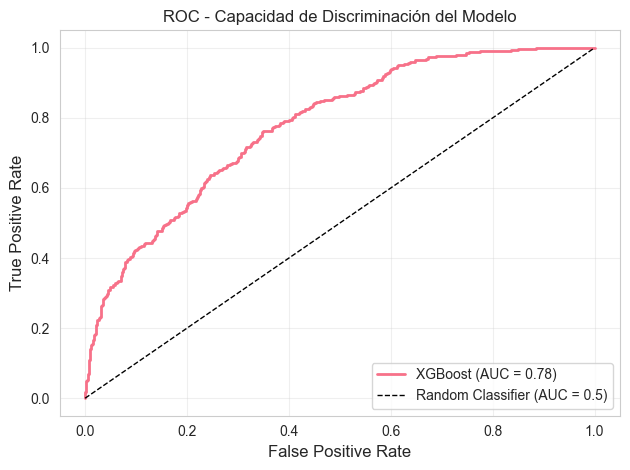

ROC-AUC Score: 0.780


In [137]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, linewidth=2, label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier (AUC = 0.5)')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC - Capacidad de Discriminación del Modelo')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"ROC-AUC Score: {roc_auc:.3f}")

#### Implementación del modelo final

Guardaremos nuestro pipeline entrenado para acceder a él posteriormente en nuestra app

In [23]:
import pickle

with open('xgb_pipeline-0.1.0.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Si se diese el caso de ser un modelo demasiado grande ejecutaríamos 
#!zip -r ./xgb_model-0.1.0.pkl.zip ./xgbmodel-0.1.0.pkl

## Interpretación del Modelo y Análisis de Patrones de Churn

### Feature Importance: Variables Más Predictivas

La importancia de variables en XGBoost cuantifica la contribución relativa de cada feature en las decisiones de splitting del modelo:

In [ ]:
importancias = grid_search.best_estimator_.feature_importances_

importance_df = pd.DataFrame({
    "variable": X_train.columns,
    "importancia": importancias
}).sort_values("importancia", ascending=False)

importance_df

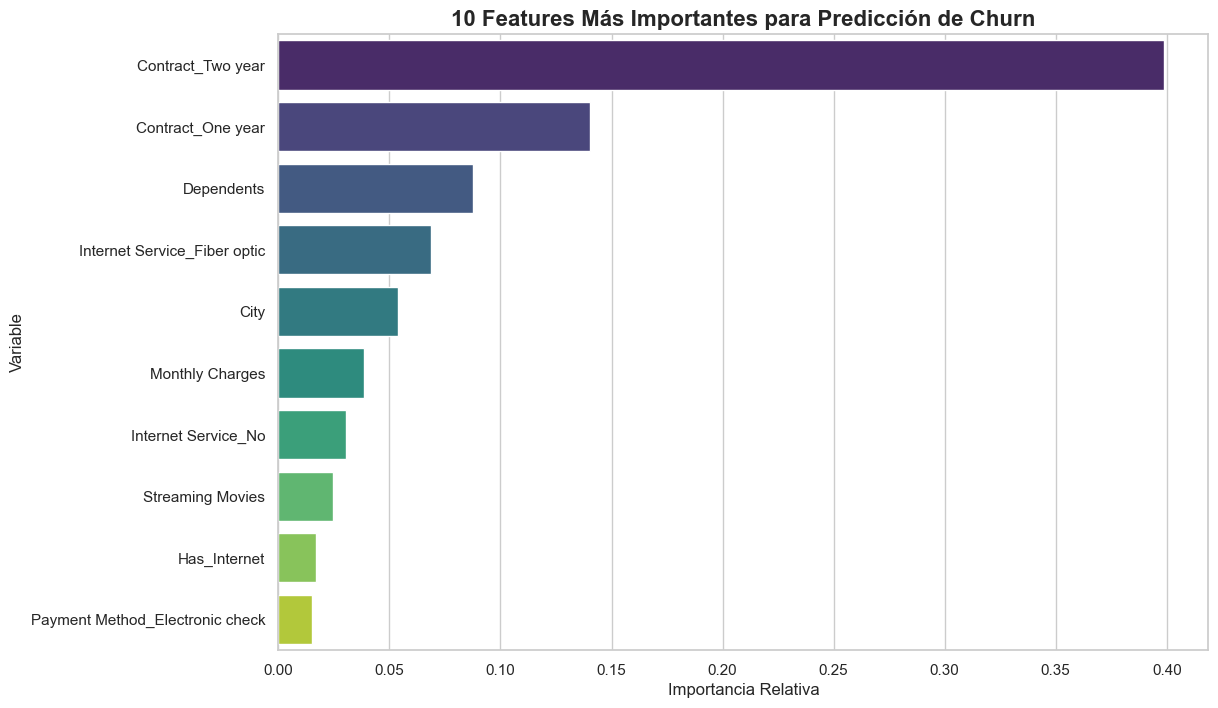

In [160]:
plt.figure(figsize=(12, 8))
top_n = 10
sns.barplot(data=importance_df.head(top_n),y='Feature', x='Importance', hue='Feature', palette='viridis', legend=False)
plt.title(f'{top_n} Features Más Importantes para Predicción de Churn', fontsize=16, fontweight='bold')
plt.xlabel('Importancia Relativa', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.show()

Vemos que el tipo de contrato ayuda significativamente al modelo a predecir si el cliente abandona o no. De esta forma, individuos con un contrato de dos años tienen mucha menos probabilidad de abandonar que aquellos con un contrato de mes a mes. 

Por otro lado, el número de personas dependientes también influye en gran medida, posiblemente ya que dichos usuarios prefieran la comodidad de permanecer con la compañía y no tener que gestionar cambios, prefiriendo al estabilidad.

Destacan también variables como tener contratado el servicio de fibra óptica o la ciudad de residencia del individuo, sugiriendo que en algunas ciudades puede haber mayor tasa de abandono que en otras (esto puede reflejar un mejor servicio o atención al cliente dependiendo de la ciudad).

A continuación, indagaremos en los motivos de abandono para entender exactamente las causas que hay detrás. 

### Mayores motivos de abandono

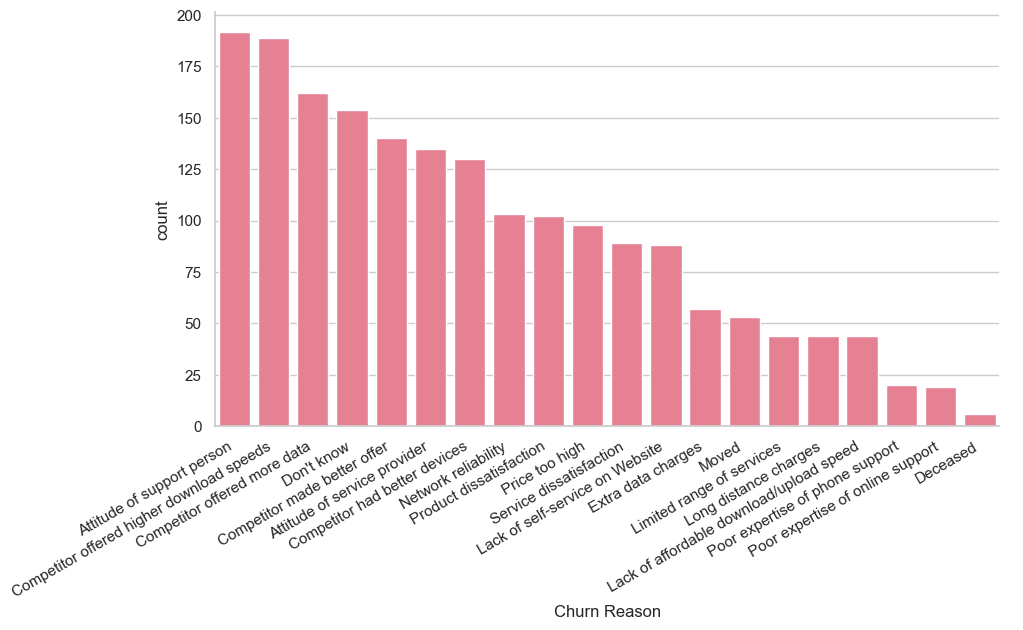

In [159]:
sns.set_style('whitegrid')
order = df['Churn Reason'].value_counts().index
g = sns.catplot(data=df,x='Churn Reason',kind='count',order=order,aspect=1.8)
g.set_xticklabels(rotation=30, ha='right')


Se debe mejorar la actitud del personal de servicio al cliente, ya que este es el motivo más frecuente de abandono de la compañía, seguido de ofertas ofrecidas por competidores

Ahora nos enfocaremos en la variable que más ayudaba a distinguir al modelo XGBoost, el tipo de contrato. Para ello, graficaremos el ratio de abandono que hay según el tipo de contrato y lo compararemos frente a la media.

Text(0.5, 1.0, 'Ratio de abandono según tipo de contrato')

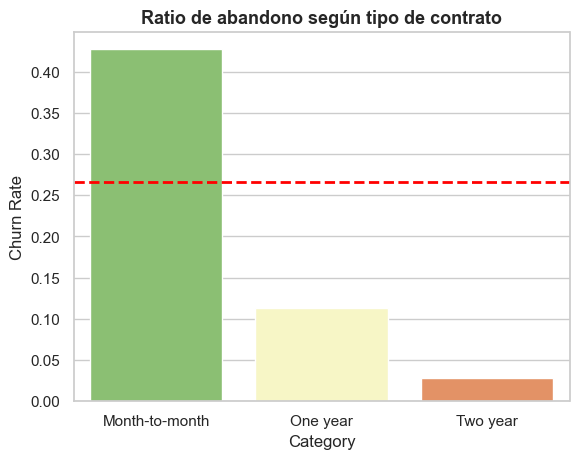

In [161]:
churn_rate = df.groupby('Contract')['Churn Value'].mean().sort_values(ascending=False)
counts = df['Contract'].value_counts()
    
plot_data = pd.DataFrame({
    'Category': churn_rate.index,
    'Churn Rate': churn_rate.values,
    'Count': counts[churn_rate.index].values
})

bars = sns.barplot(
    data=plot_data,
    x='Category',
    y='Churn Rate',
    hue = 'Category',
    legend=False,
    palette='RdYlGn_r'
)
    
avg_churn = df['Churn Value'].mean()
plt.axhline(avg_churn, color='red', linestyle='--', linewidth=2, label=f'Promedio: {avg_churn:.2%}')
plt.title('Ratio de abandono según tipo de contrato', fontsize=13, fontweight='bold')


Comprobamos que los contratos de mes a mes representan un ratio muy superior a los de uno o dos años. Otra prioridad de la empresa debería ser también conseguir cambiar este tipo de contratos a unos más longevos, que tienen menor tasa de abandono.

Finalmente, indagaremos en las ciudades que tienen un ratio de abandono más alto, y que por tanto deberían de ser evaluadas cuidadosamente.

Text(0.5, 1.0, '15 ciudades con mayor ratio de abandono')

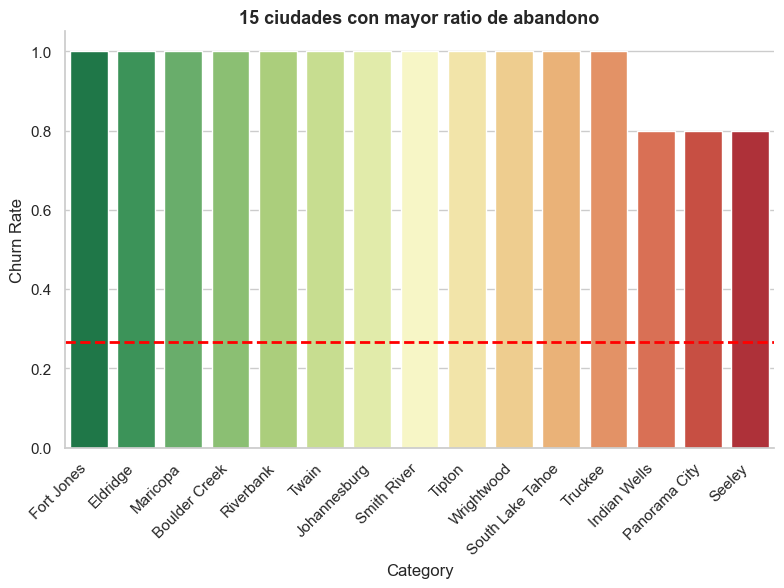

In [162]:
city_churn_rate = df.groupby('City')['Churn Value'].mean().sort_values(ascending=False).head(15)
counts = df['City'].value_counts().loc[city_churn_rate.index]

city_plot_data = pd.DataFrame({
    'Category': city_churn_rate.index,
    'Churn Rate': city_churn_rate.values,
    'Count': counts[city_churn_rate.index].values
})

bars = sns.catplot(
    data=city_plot_data,
    x='Category',
    y='Churn Rate',
    kind='bar',
    hue = 'Category',
    legend=False,
    palette='RdYlGn_r',
    aspect = 1.6
)

bars.set_xticklabels(rotation=45, ha='right')

avg_churn = df['Churn Value'].mean()
plt.axhline(avg_churn, color='red', linestyle='--', linewidth=2)
plt.title('15 ciudades con mayor ratio de abandono', fontsize=13, fontweight='bold')


Investigaremos estas ciudades (con ratio de abandono 1) visualizando los principales motivos de abandono por cada ciudad de las seleeccionadas

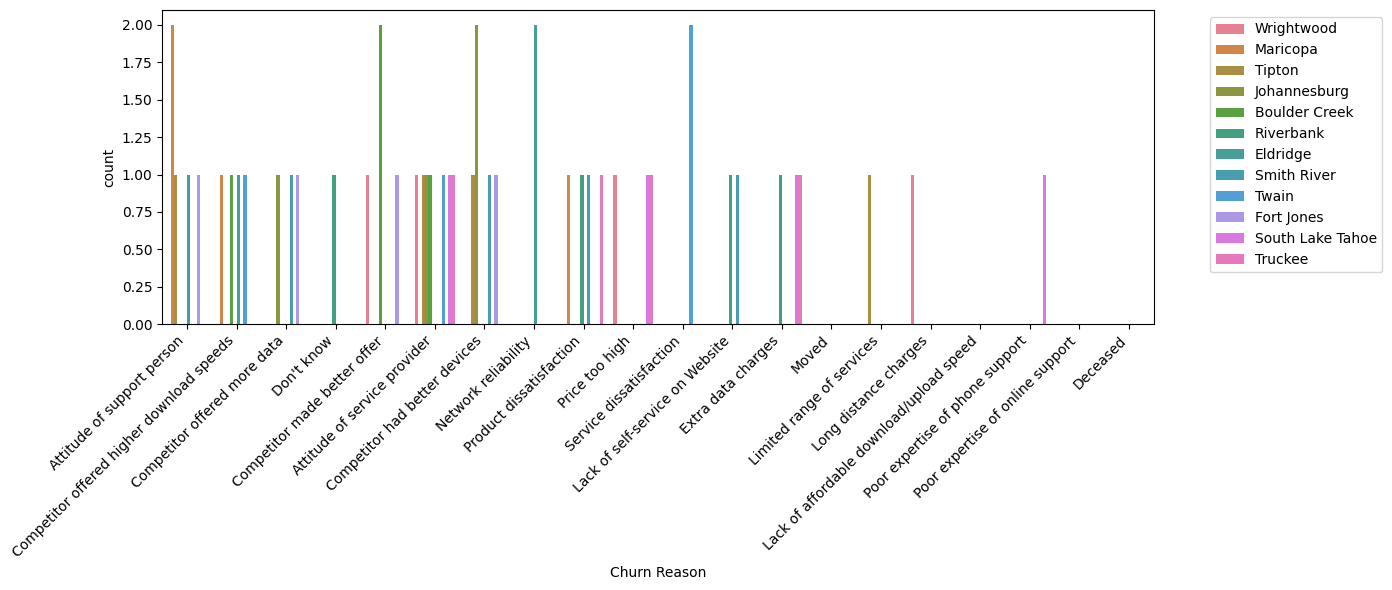

In [10]:
cities = ['Fort Jones', 'Eldridge', 'Maricopa', 'Boulder Creek', 'Riverbank', 
          'Twain', 'Johannesburg', 'Smith River', 'Tipton', 'Wrightwood', 
          'South Lake Tahoe', 'Truckee']

df_cities = df[df['City'].isin(cities)]

plt.figure(figsize=(14, 6))
sns.countplot(data=df_cities, x='Churn Reason', hue='City', order=order)
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
plt.show()

## Aprendizaje no supervisado
### Segmentación de usuarios

En este apartado nos enfocaremos en el aprendizaje no supervisado, partiendo de un escenario en el que no contamos con variables relacionadas con el abandono de clientes. Esto nos permitirá, de manera complementaria, entender patrones y comportamientos que ayudan a identificar qué tipos de clientes tenemos en la base de datos.

Empezaremos calculando la matriz de correlaciones para entender cómo se comportan nuestras variables

In [61]:
from sklearn.preprocessing import StandardScaler

bool_cols = ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Online Security', 'Online Backup', 'Device Protection', 
             'Tech Support', 'Streaming TV', 'Streaming Movies', 'Paperless Billing']
num_cols = ['Tenure Months', 'Monthly Charges', 'Total Charges']
cat_cols = ['Internet Service', 'Contract', 'Payment Method']

preprocessor = ColumnTransformer([
    ('bool_encoder', OrdinalEncoder(categories=[['No', 'Yes']]*len(bool_cols)), bool_cols),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False), cat_cols),
    ('gender_encoder', OrdinalEncoder(categories=[['Male', 'Female']]), ['Gender']),
    ('scaler', StandardScaler(), num_cols)
], remainder='passthrough')

df = df.drop(columns=['City', 'Churn Value', 'Churn Score', 'CLTV'])
X_scaled = preprocessor.fit_transform(df)


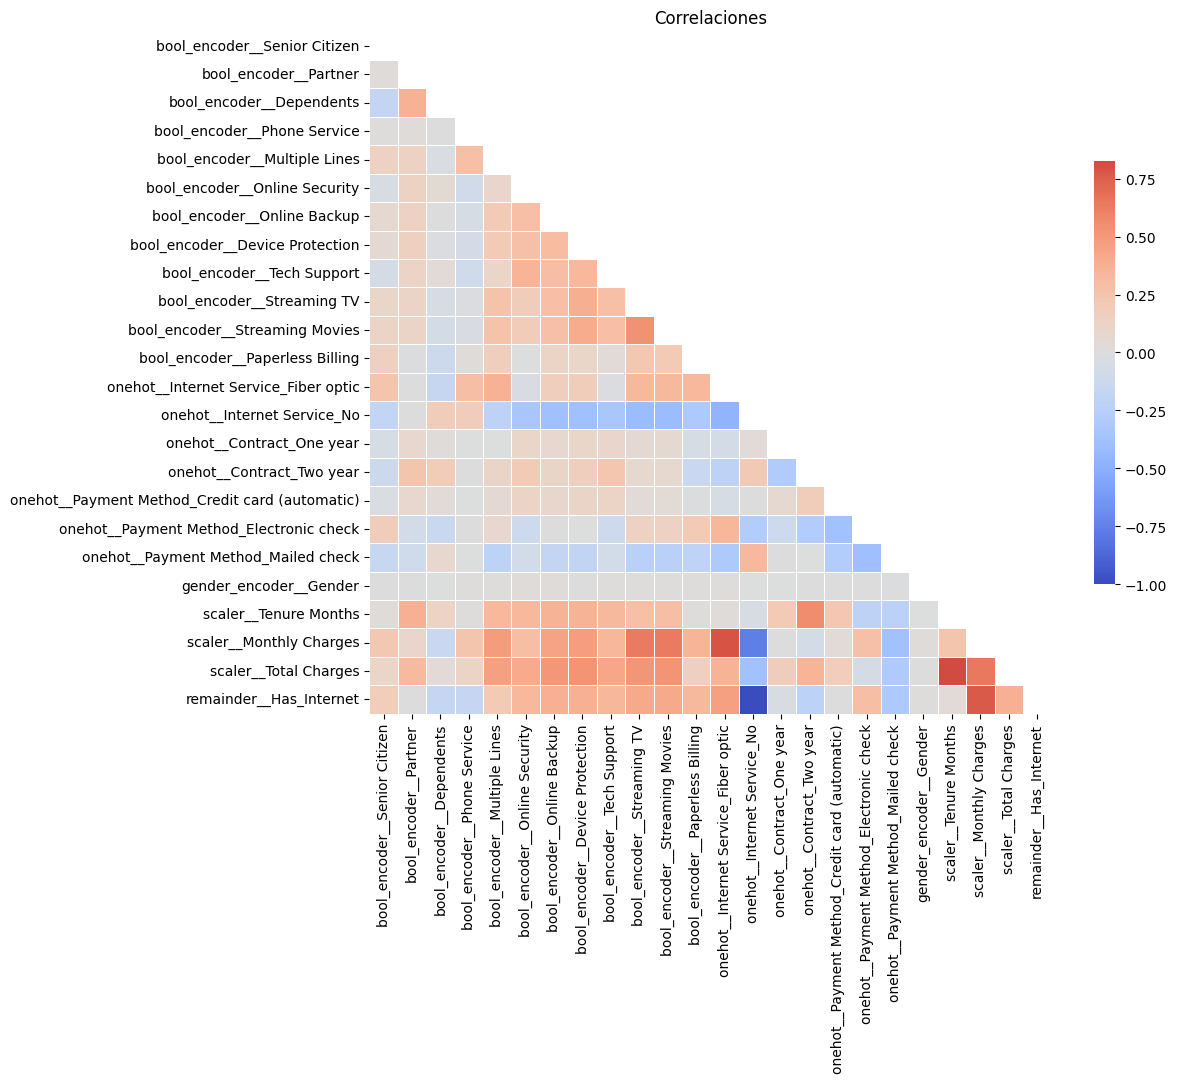

In [78]:
corr = X_scaled_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(11, 11))
sns.heatmap(corr, square=True, mask=mask, linewidths=.5, cmap='coolwarm', center=0, cbar_kws={"shrink": .5})
plt.title('Correlaciones')
plt.show()

#### K-means

Ahora agruparemos a los usuarios mediante la técnica K-Means, y los proyectaremos en las dimensiones latentes del PCA.

Para ello, seleccionaremos el número óptimo de clusters fijándonos en las métricas de Silhouette y WSS

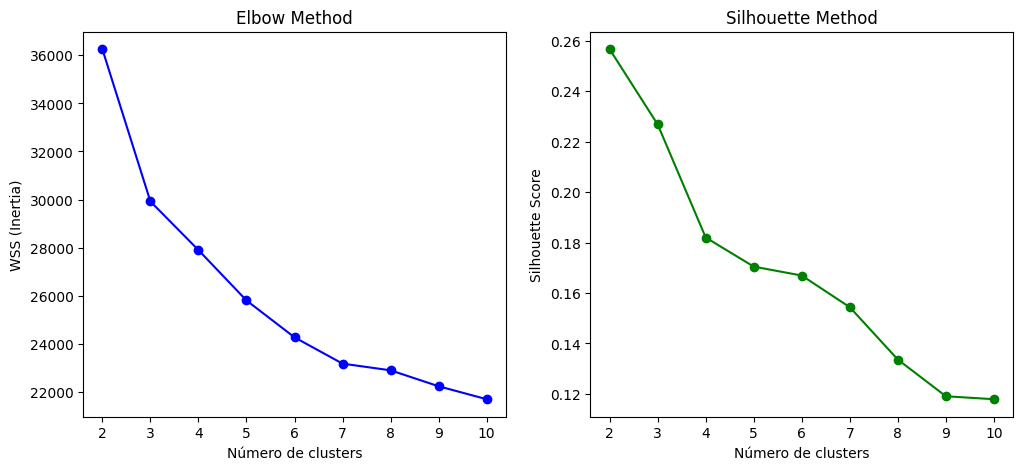

In [62]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

wss = []
sil_scores = []

K_range = range(2, 11)  

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    labels = kmeans.fit_predict(X_scaled)
    
    # WSS = inertia_ de KMeans
    wss.append(kmeans.inertia_)
    
    # Silhouette score promedio
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

# Graficar Elbow (WSS)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, wss, 'o-', color='blue')
plt.xlabel('Número de clusters')
plt.ylabel('WSS (Inertia)')
plt.title('Elbow Method')

# Graficar Silhouette
plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, 'o-', color='green')
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')

plt.show()

Agrupamos 5 clusters, ya que para dicho número de clusters encontramos una buena combinación entre Silhouette y un WSS más reducido.

In [64]:
kmeans = KMeans(n_clusters=5, random_state=RANDOM_STATE)
df['cluster'] = kmeans.fit_predict(X_scaled)

#### PCA

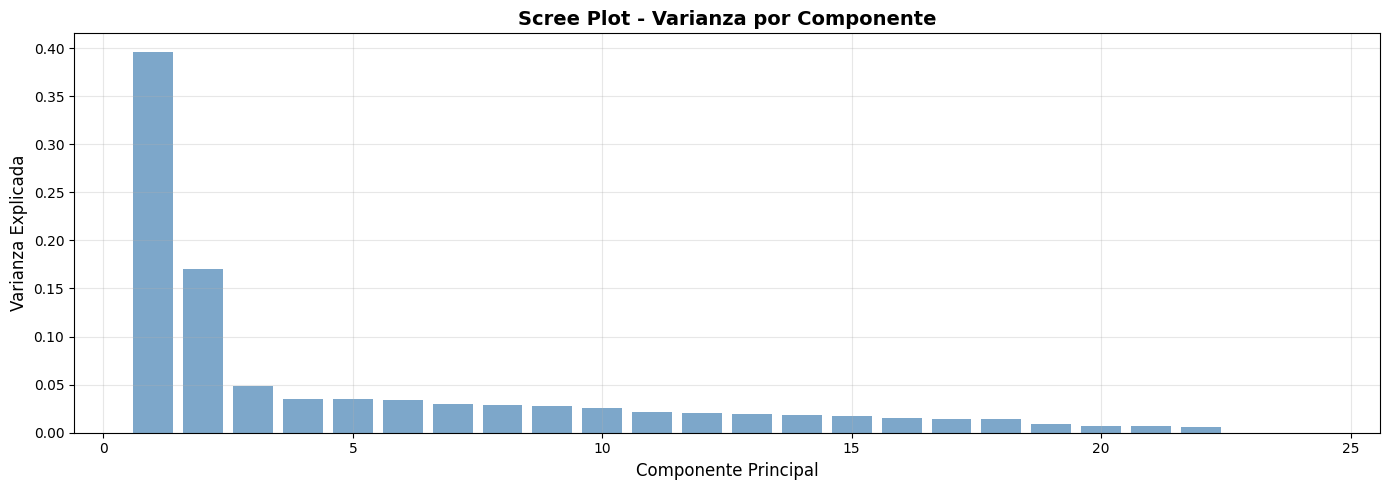

In [72]:
from sklearn.decomposition import PCA

pca = PCA(random_state=RANDOM_STATE)
pca.fit(X_scaled)

# Calcular varianza explicada
varianza_explicada = pca.explained_variance_ratio_
varianza_acumulada = np.cumsum(varianza_explicada)

plt.figure(figsize=(14, 5))

plt.bar(range(1, len(varianza_explicada) + 1), varianza_explicada, 
            alpha=0.7, color='steelblue')
plt.xlabel('Componente Principal', fontsize=12)
plt.ylabel('Varianza Explicada', fontsize=12)
plt.title('Varianza por Componente', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Seleccionamos las 2 primeras componentes del PCA, ya que explican casi la totalidad de la varianza

Ahora proyectaremos nuestros clusters sobre dichas dimensiones del PCA

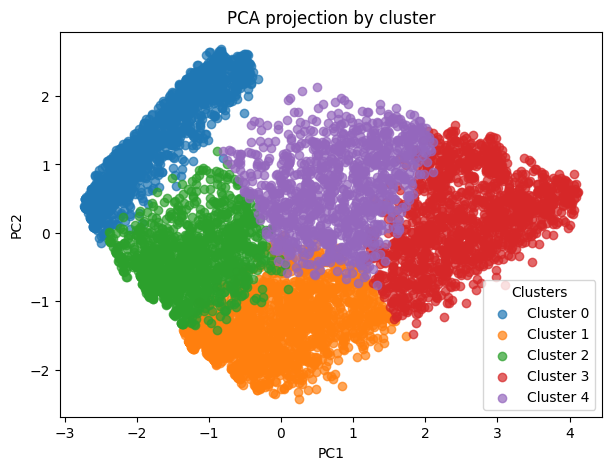

In [73]:
from sklearn.decomposition import PCA

pca = PCA(2) 
X2 = pca.fit_transform(X_scaled) 

clusters = df["cluster"].values
unique_clusters = np.unique(clusters)

plt.figure(figsize=(7,5))

for c in unique_clusters:
    mask = clusters == c
    plt.scatter(
        X2[mask, 0],
        X2[mask, 1],
        label=f"Cluster {c}",
        alpha=0.7
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Clusters")
plt.title("PCA projection by cluster")
plt.show()

Para facilitar la comprensión del PCA, calcularemos un mapa de calor de nuestras variables con las dimensiones latentes.

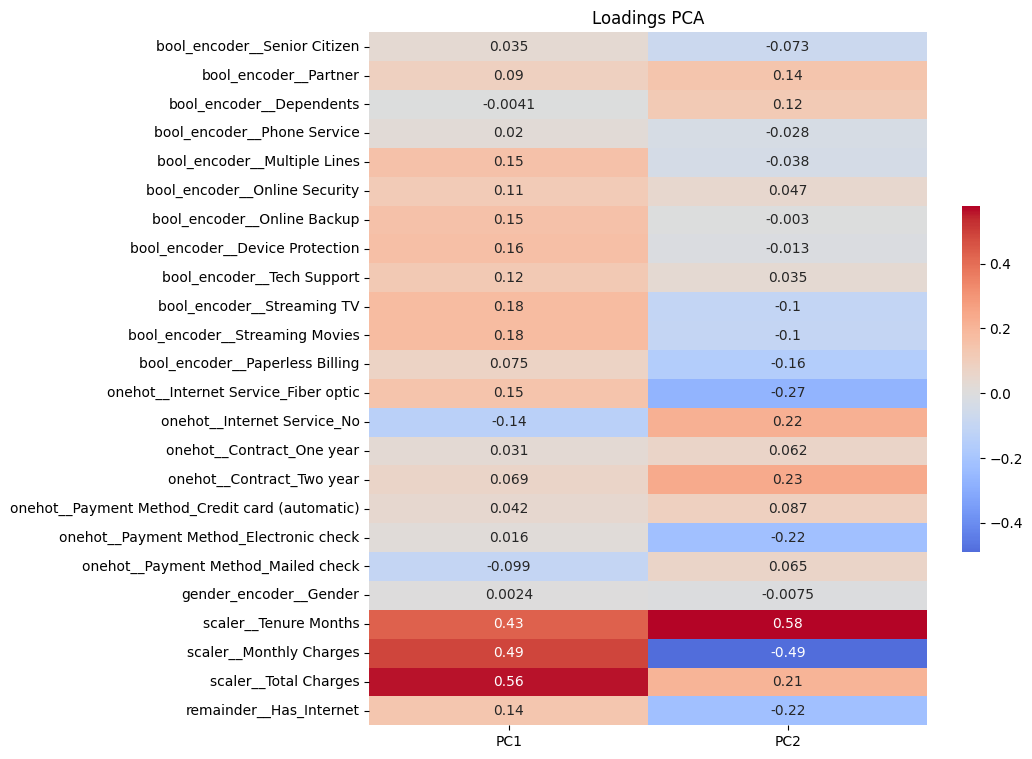

In [74]:
feature_names = preprocessor.get_feature_names_out()
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)

loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=(X_scaled_df).columns
)

plt.figure(figsize=(9,9))
sns.heatmap(loadings, annot=True, cmap="coolwarm", center=0, cbar_kws={"shrink": .5})
plt.title("Loadings PCA")
plt.show()

#### Análisis Clustering y PCA

Las variables que más ayudan a identificar a los individuos son el número y la cantidad total de pagos, así como los meses que ha permanecido el cliente. En definitiva, podemos observar que la antigüedad de un cliente es la información que más ayuda distinguir entre los distintos tipos de usuarios.

-La primera componente refleja el tiempo que el cliente lleva con la compañía, así como la cantidad de pagos que ha hecho, lo que podría reflejar el nivel de tarifa contratada. Valores altos en esta componente representaría a un perfil que lleva con la empresa muchos años, y/o que a su vez tiene contratado un plan más elevado.

-La segunda componente distingue entre longevidad y la cantidad que paga el cliente. Individuos con valores altos representan usuarios que efectivamente llevan mucho tiempo, mientras que valores bajos indican que se tiene contratado el plan más sencillo, o que lleva muy poco tiempo con la empresa.

Fijándonos en el gráfico de individuos del PCA, interpretamos los siguientes clusters:

- Cluster 0: son clientes relativamente nuevos, pero a los que se les cobra una mensualidad alta. Posiblemente son usuarios que han contratado un plan más elevado y de mayor precio.
- Cluster 1: representa a clientes que ya llevan algo de tiempo, pero que tienen contratada una mensualidad más baja. 
- Cluster 2: clientes muy nuevos en la compañía, y que por tanto no se dispone de mucha información sobre sus transacciones.
- Cluster 3: agrupa al perfil de usuarios que lleva más tiempo y que ha realizado más transacciones. Individuos pertenecientes a este cluster representan un bajo riesgo de abandono.
- Cluster 4: este cluster contiene clientes estándar, que llevan algo de tiempo con la compañía y una cantidad de transacciones media-elevada. En general, no parece representar un sector de alto riesgo de abandono.